In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import copy
import matplotlib.pyplot as plt

from utils import MaskedForward

In [8]:
# Configuración
batch_size = 64
threshold_accuracy = 0.70
sparsity_percentage = 0.1  # Porcentaje de pesos a conservar (más altos)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])

data_dir = '../../data/cifar10'

train_dataset = datasets.CIFAR10(root= data_dir, train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root= data_dir, train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
net = models.alexnet(pretrained=False)
net.classifier[6] = nn.Linear(net.classifier[6].in_features, 10)

mask = models.alexnet(pretrained=False)
mask.classifier[6] = nn.Linear(mask.classifier[6].in_features, 10)

net.to(device)
mask.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
# Congelar los parámetros de net (no se entrenarán)
for param in net.parameters():
    param.requires_grad = False

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mask.parameters(), lr=0.001)
epoch = 0
saved = False
losses = []
accuracies = []

while True:
    masked_model = MaskedForward(net, mask, sparsity_percentage).to(device)
    # Guardar copia de los pesos de net para verificar que no cambian
    # net_before = [p.clone().detach() for p in net.parameters()]
    masked_model.train()
    running_loss = 0.0

    epoch += 1

    print(f"\n===== Epoch {epoch} =====")

        # Guardar copia de los pesos de mask
    # mask_before = [p.clone().detach() for p in mask.parameters()]

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
    
        optimizer.zero_grad()
        outputs = masked_model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # # Verificar gradientes
        # for name, param in mask.named_parameters():
        #     if param.grad is not None:
        #         print(f"[Grad] {name}: grad norm = {param.grad.norm().item():.6f}")
        #     else:
        #         print(f"[Grad] {name}: NO grad")
        optimizer.step()

        running_loss += loss.item()
        # if batch_idx % 10 == 0:
        #     print(f"Batch {batch_idx}, Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    # Evaluación
    masked_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = masked_model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100.0 * correct / total
    accuracies.append(accuracy)

    #     # Verificar cambios en los parámetros de mask
    # for (before, after), name in zip(zip(mask_before, mask.parameters()), mask.state_dict().keys()):
    #     delta = (after - before).abs().sum().item()
    #     print(f"[Update] {name}: Δ = {delta:.6f}")

    # # Verificar que net no ha sido modificado
    # for (before, after), name in zip(zip(net_before, net.parameters()), net.state_dict().keys()):
    #     delta = (after - before).abs().sum().item()
    #     print(f"[Check Net] {name}: Δ = {delta:.6f}")

    print(f"Epoch {epoch}: Avg Loss = {avg_loss:.4f}, Test Accuracy = {accuracy:.2f}%")

    if accuracy >= threshold_accuracy * 100:
        print("Reached target accuracy. Stopping training.")
        if not saved:
            # Guardar net y mask
            torch.save(net.state_dict(), "./models/net2.pth")
            torch.save(mask.state_dict(), "./models/mask2.pth")
            print(f"(Models saved)")
            saved = True
        else:
            print("Model already saved, skipping save.")
        break



===== Epoch 1 =====
Epoch 1: Avg Loss = 1.9173, Test Accuracy = 36.27%

===== Epoch 2 =====
Epoch 2: Avg Loss = 1.6354, Test Accuracy = 42.63%

===== Epoch 3 =====
Epoch 3: Avg Loss = 1.5216, Test Accuracy = 48.04%

===== Epoch 4 =====
Epoch 4: Avg Loss = 1.4527, Test Accuracy = 49.42%

===== Epoch 5 =====
Epoch 5: Avg Loss = 1.4074, Test Accuracy = 50.17%

===== Epoch 6 =====
Epoch 6: Avg Loss = 1.3853, Test Accuracy = 50.59%

===== Epoch 7 =====
Epoch 7: Avg Loss = 1.3608, Test Accuracy = 50.44%

===== Epoch 8 =====
Epoch 8: Avg Loss = 1.3509, Test Accuracy = 52.11%

===== Epoch 9 =====
Epoch 9: Avg Loss = 1.3314, Test Accuracy = 53.05%

===== Epoch 10 =====
Epoch 10: Avg Loss = 1.3276, Test Accuracy = 52.62%

===== Epoch 11 =====
Epoch 11: Avg Loss = 1.3177, Test Accuracy = 53.96%

===== Epoch 12 =====
Epoch 12: Avg Loss = 1.3160, Test Accuracy = 54.22%

===== Epoch 13 =====
Epoch 13: Avg Loss = 1.3113, Test Accuracy = 54.61%

===== Epoch 14 =====
Epoch 14: Avg Loss = 1.3083, Test 

KeyboardInterrupt: 

In [13]:
torch.save(net.state_dict(), "net_cifar.pth")
torch.save(mask.state_dict(), "mask_cifar.pth")
print(f"Models saved")

Models saved


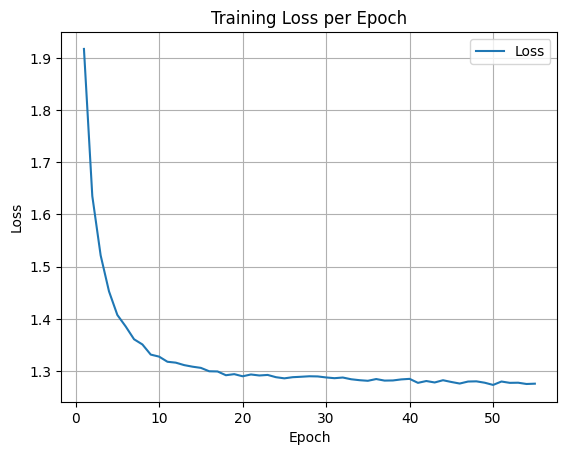

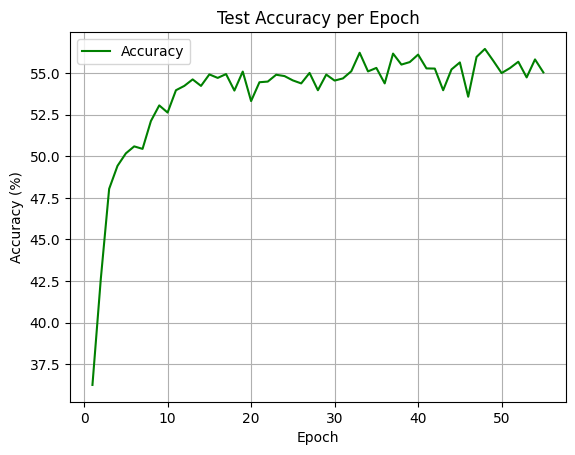

In [14]:
# Gráficos de pérdida y precisión
plt.figure()
plt.plot(range(1, len(losses)+1), losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(accuracies)+1), accuracies, label='Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(losses)
print(len(losses))
print(accuracies)
print(len(accuracies))
print(epoch)

[2.2170420914161495, 2.210403504895001, 2.20872983990646, 2.2054849048940146, 2.203337568335417, 2.1812992859177474, 2.1163125706882013, 2.0738425618264733, 2.0081008447379602, 1.9724520506655299, 1.9343535573017308, 1.9164086144144943, 1.8872428176606573, 1.8678179910270178, 1.8420520751941494, 1.8266336543530952, 1.8075370406959115, 1.7981911715937824, 1.7817181657727172, 1.7800613209241773, 1.763525407852196, 1.7456517074166276, 1.7391322578598813, 1.732369231014717, 1.719978434647002, 1.7124404783655958, 1.7064867452150438, 1.7002490944251782, 1.686897015426217, 1.675776308993014, 1.6714007472846566, 1.6656225138321155, 1.6612524684609435, 1.6489834640084244, 1.6368283716643728, 1.6256374298799328, 1.6279751011511174, 1.627916256829006, 1.6139364922192039, 1.6059013623289946, 1.604185411115972, 1.5970091543546536, 1.585404064597153, 1.5934951472573164, 1.5759431817909566, 1.575899345482268, 1.5717612763003606, 1.5666650246556213, 1.5573022478237384, 1.554019751345239, 1.55515429341